In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/home/gridsan/qwang/urban-control/")

from src.train_controlnet import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
parser = argparse.ArgumentParser(description="Simple example of a ControlNet training script.")
parser.add_argument(
    "--pretrained_model_name_or_path",
    type=str,
    default=None,
    required=True,
    help="Path to pretrained model or model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--controlnet_model_name_or_path",
    type=str,
    default=None,
    help="Path to pretrained controlnet model or model identifier from huggingface.co/models."
    " If not specified controlnet weights are initialized from unet.",
)
parser.add_argument(
    "--revision",
    type=str,
    default=None,
    required=False,
    help="Revision of pretrained model identifier from huggingface.co/models.",
)
parser.add_argument(
    "--variant",
    type=str,
    default=None,
    help="Variant of the model files of the pretrained model identifier from huggingface.co/models, 'e.g.' fp16",
)
parser.add_argument(
    "--tokenizer_name",
    type=str,
    default=None,
    help="Pretrained tokenizer name or path if not the same as model_name",
)
parser.add_argument(
    "--output_dir",
    type=str,
    default="controlnet-model",
    help="The output directory where the model predictions and checkpoints will be written.",
)
parser.add_argument(
    "--cache_dir",
    type=str,
    default=None,
    help="The directory where the downloaded models and datasets will be stored.",
)
parser.add_argument("--seed", type=int, default=None, help="A seed for reproducible training.")
parser.add_argument(
    "--resolution",
    type=int,
    default=512,
    help=(
        "The resolution for input images, all the images in the train/validation dataset will be resized to this"
        " resolution"
    ),
)
parser.add_argument(
    "--train_batch_size", type=int, default=4, help="Batch size (per device) for the training dataloader."
)
parser.add_argument("--num_train_epochs", type=int, default=1)
parser.add_argument(
    "--max_train_steps",
    type=int,
    default=None,
    help="Total number of training steps to perform.  If provided, overrides num_train_epochs.",
)
parser.add_argument(
    "--checkpointing_steps",
    type=int,
    default=500,
    help=(
        "Save a checkpoint of the training state every X updates. Checkpoints can be used for resuming training via `--resume_from_checkpoint`. "
        "In the case that the checkpoint is better than the final trained model, the checkpoint can also be used for inference."
        "Using a checkpoint for inference requires separate loading of the original pipeline and the individual checkpointed model components."
        "See https://huggingface.co/docs/diffusers/main/en/training/dreambooth#performing-inference-using-a-saved-checkpoint for step by step"
        "instructions."
    ),
)
parser.add_argument(
    "--checkpoints_total_limit",
    type=int,
    default=None,
    help=("Max number of checkpoints to store."),
)
parser.add_argument(
    "--resume_from_checkpoint",
    type=str,
    default=None,
    help=(
        "Whether training should be resumed from a previous checkpoint. Use a path saved by"
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
    ),
)
parser.add_argument(
    "--gradient_accumulation_steps",
    type=int,
    default=1,
    help="Number of updates steps to accumulate before performing a backward/update pass.",
)
parser.add_argument(
    "--gradient_checkpointing",
    action="store_true",
    help="Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass.",
)
parser.add_argument(
    "--learning_rate",
    type=float,
    default=5e-6,
    help="Initial learning rate (after the potential warmup period) to use.",
)
parser.add_argument(
    "--scale_lr",
    action="store_true",
    default=False,
    help="Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size.",
)
parser.add_argument(
    "--lr_scheduler",
    type=str,
    default="constant",
    help=(
        'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
        ' "constant", "constant_with_warmup"]'
    ),
)
parser.add_argument(
    "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
)
parser.add_argument(
    "--lr_num_cycles",
    type=int,
    default=1,
    help="Number of hard resets of the lr in cosine_with_restarts scheduler.",
)
parser.add_argument("--lr_power", type=float, default=1.0, help="Power factor of the polynomial scheduler.")
parser.add_argument(
    "--use_8bit_adam", action="store_true", help="Whether or not to use 8-bit Adam from bitsandbytes."
)
parser.add_argument(
    "--dataloader_num_workers",
    type=int,
    default=0,
    help=(
        "Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."
    ),
)
parser.add_argument("--adam_beta1", type=float, default=0.9, help="The beta1 parameter for the Adam optimizer.")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
parser.add_argument("--adam_weight_decay", type=float, default=1e-2, help="Weight decay to use.")
parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
parser.add_argument(
    "--hub_model_id",
    type=str,
    default=None,
    help="The name of the repository to keep in sync with the local `output_dir`.",
)
parser.add_argument(
    "--logging_dir",
    type=str,
    default="logs",
    help=(
        "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
        " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
    ),
)
parser.add_argument(
    "--allow_tf32",
    action="store_true",
    help=(
        "Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see"
        " https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"
    ),
)
parser.add_argument(
    "--report_to",
    type=str,
    default="tensorboard",
    help=(
        'The integration to report the results and logs to. Supported platforms are `"tensorboard"`'
        ' (default), `"wandb"` and `"comet_ml"`. Use `"all"` to report to all integrations.'
    ),
)
parser.add_argument(
    "--mixed_precision",
    type=str,
    default=None,
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >="
        " 1.10.and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the"
        " flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."
    ),
)
parser.add_argument(
    "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
)
parser.add_argument(
    "--set_grads_to_none",
    action="store_true",
    help=(
        "Save more memory by using setting grads to None instead of zero. Be aware, that this changes certain"
        " behaviors, so disable this argument if it causes any problems. More info:"
        " https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html"
    ),
)
parser.add_argument(
    "--dataset_name",
    type=str,
    default=None,
    help=(
        "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
        " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
        " or to a folder containing files that 🤗 Datasets can understand."
    ),
)
parser.add_argument(
    "--dataset_config_name",
    type=str,
    default=None,
    help="The config of the Dataset, leave as None if there's only one config.",
)
parser.add_argument(
    "--train_data_dir",
    type=str,
    default=None,
    help=(
        "A folder containing the training data. Folder contents must follow the structure described in"
        " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
        " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
    ),
)

parser.add_argument(
    "--validation_data_dir",
    type=str,
    default=None,
    help=(
        "A folder containing the validation data. Folder contents must follow the structure described in"
        " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
        " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
    ),
)
parser.add_argument(
    "--image_column", type=str, default="image", help="The column of the dataset containing the target image."
)
parser.add_argument(
    "--conditioning_image_column",
    type=str,
    default="conditioning_image",
    help="The column of the dataset containing the controlnet conditioning image.",
)
parser.add_argument(
    "--caption_column",
    type=str,
    default="text",
    help="The column of the dataset containing a caption or a list of captions.",
)
parser.add_argument(
    "--max_train_samples",
    type=int,
    default=None,
    help=(
        "For debugging purposes or quicker training, truncate the number of training examples to this "
        "value if set."
    ),
)
parser.add_argument(
    "--proportion_empty_prompts",
    type=float,
    default=0,
    help="Proportion of image prompts to be replaced with empty strings. Defaults to 0 (no prompt replacement).",
)
parser.add_argument(
    "--validation_prompt",
    type=str,
    default=None,
    nargs="+",
    help=(
        "A set of prompts evaluated every `--validation_steps` and logged to `--report_to`."
        " Provide either a matching number of `--validation_image`s, a single `--validation_image`"
        " to be used with all prompts, or a single prompt that will be used with all `--validation_image`s."
    ),
)
parser.add_argument(
    "--validation_image",
    type=str,
    default=None,
    nargs="+",
    help=(
        "A set of paths to the controlnet conditioning image be evaluated every `--validation_steps`"
        " and logged to `--report_to`. Provide either a matching number of `--validation_prompt`s, a"
        " a single `--validation_prompt` to be used with all `--validation_image`s, or a single"
        " `--validation_image` that will be used with all `--validation_prompt`s."
    ),
)
parser.add_argument(
    "--num_validation_images",
    type=int,
    default=4,
    help="Number of images to be generated for each `--validation_image`, `--validation_prompt` pair",
)
parser.add_argument(
    "--validation_steps",
    type=int,
    default=100,
    help=(
        "Run validation every X steps. Validation consists of running the prompt"
        " `args.validation_prompt` multiple times: `args.num_validation_images`"
        " and logging the images."
    ),
)
parser.add_argument(
    "--tracker_project_name",
    type=str,
    default="train_controlnet",
    help=(
        "The `project_name` argument passed to Accelerator.init_trackers for"
        " more information see https://huggingface.co/docs/accelerate/v0.17.0/en/package_reference/accelerator#accelerate.Accelerator"
    ),
)

_StoreAction(option_strings=['--tracker_project_name'], dest='tracker_project_name', nargs=None, const=None, default='train_controlnet', type=<class 'str'>, choices=None, help='The `project_name` argument passed to Accelerator.init_trackers for more information see https://huggingface.co/docs/accelerate/v0.17.0/en/package_reference/accelerator#accelerate.Accelerator', metavar=None)

In [8]:
input_args = ["--pretrained_model_name_or_path","models/stable-diffusion-v1-5",
              "--output_dir","output",
              "--seed","555",
              "--num_train_epochs", "1",
              "--checkpoints_total_limit", "10",
              "--gradient_accumulation_steps", "4",
              "--learning_rate", "2e-5",
              "--lr_scheduler", "cosine",
              "--lr_warmup_steps", "500",
              "--mixed_precision", "fp16",
              "--train_data_dir", "./data/train/20250414_v0_train.csv",
              "--validation_data_dir", "./data/train/20250414_v0_validation.csv",
              "--image_column","image_column",
              "--conditioning_image_column","conditioning_image_column",
              "--caption","caption",
              "--tracker_project_name","20250414_v0_test",
              "--validation_image", "./data/validation/chicago_16803_24339.png", "./data/validation/chicago_16812_24354.png", "./data/validation/la_11199_26119.png", "./data/validation/la_11207_26155.png",
              "--validation_prompt", 
              "This is a satellite image of la where the city forms the core. In terms of settlement, you'll find mostly residential (55%) in this zone , with pockets of recreational (30%) . Building density is low in this area. Furthermore, single-family homes structures dominate the residential areas.", 
              "This is a satellite image of city in dallas. This area is dominated by residential (35%) , with pockets of commercial (20%), recreational (15%), parking (5%) . Building density is high in this area. single-family homes structures dominate the residential areas.",
              "This is a satellite image of city in chicago. In terms of settlement, residential areas (50%) prevail here , with pockets of industrial (15%), recreational (15%) . This area has a medium building density. Furthermore, housing consists primarily of single-family homes.",
              "This is a satellite image of city in la. Additionally, the landscape is primarily residential (40%) , complemented by commercial (30%), industrial (15%), parking (5%) . This area has a high building density. Furthermore, apartment complexes structures dominate the residential areas , complemented by single-family homes.",
              "--enable_xformers_memory_efficient_attention"]

In [9]:
if input_args is not None:
    args = parser.parse_args(input_args)
else:
    args = parser.parse_args()

In [10]:
if args.dataset_name is None and args.train_data_dir is None:
    raise ValueError("Specify either `--dataset_name` or `--train_data_dir`")

if args.proportion_empty_prompts < 0 or args.proportion_empty_prompts > 1:
    raise ValueError("`--proportion_empty_prompts` must be in the range [0, 1].")

if args.validation_prompt is not None and args.validation_image is None:
    raise ValueError("`--validation_image` must be set if `--validation_prompt` is set")

if args.validation_prompt is None and args.validation_image is not None:
    raise ValueError("`--validation_prompt` must be set if `--validation_image` is set")

if (
    args.validation_image is not None
    and args.validation_prompt is not None
    and len(args.validation_image) != 1
    and len(args.validation_prompt) != 1
    and len(args.validation_image) != len(args.validation_prompt)
):
    raise ValueError(
        "Must provide either 1 `--validation_image`, 1 `--validation_prompt`,"
        " or the same number of `--validation_prompt`s and `--validation_image`s"
    )

if args.resolution % 8 != 0:
    raise ValueError(
        "`--resolution` must be divisible by 8 for consistently sized encoded images between the VAE and the controlnet encoder."
    )

In [11]:
batch = main(args)

04/15/2025 03:45:06 - INFO - src.train_controlnet - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'prediction_type', 'dynamic_thresholding_ratio', 'thresholding', 'variance_type', 'rescale_betas_zero_snr', 'timestep_spacing', 'clip_sample_range', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'use_quant_conv', 'force_upcast', 'latents_mean', 'use_post_quant_conv', 'shift_factor', 'mid_block_add_attention', 'latents_std', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'transformer_layers_per_block', 'dual_cross_attention', 'addition_time_embed_dim', 'attention_type', 'conv_in_kernel', 'num_class_embeds', 'resnet_skip_time_act', 'only_cross_attention', 'resnet_out_sca

In [12]:
batch.keys()

dict_keys(['pixel_values', 'conditioning_pixel_values', 'input_ids'])

In [13]:
batch['pixel_values'].shape

torch.Size([4, 3, 512, 512])

04/15/2025 05:06:37 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

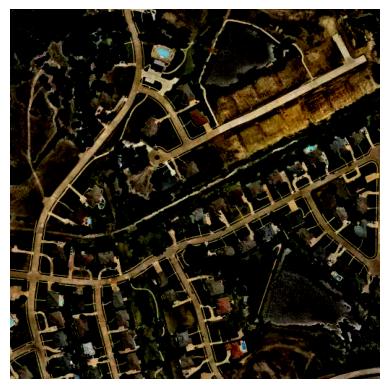

In [28]:
import matplotlib.pyplot as plt
i=2
plt.imshow(np.moveaxis(batch['pixel_values'].cpu().numpy()[i,:,:,:], (0,1,2), (2,0,1)))
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

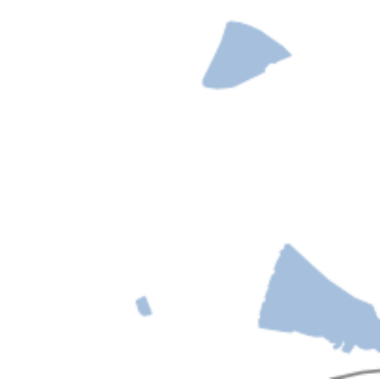

In [29]:
plt.imshow(np.moveaxis(batch['conditioning_pixel_values'].cpu().numpy()[i,:,:,:], (0,1,2), (2,0,1)))
plt.axis('off')